This code is for creating a optical tweezer/focus/trap array hologram for a phase-only Spatial Light Modulator (SLM) through the Weighted Gershberg-Saxton (GSW) algorithm, outlined by Roberto Di Leonardo, Francesca Ianni, and Giancarlo Ruocco in "Computer generation of optimal holograms for optical trap arrays," Opt. Express 15, 1913-1922 (2007) and Donggyu Kim et. al. in "Large-Scale Uniform Optical Focus Array Generation with a Phase Spatial Light Modulator," Opt. Lett. 44, 3178-3181 (2019). When illuminating the SLM with uniform amplitude plane waves and placing a lens after the SLM, the focus array is formed in the focal plane of the lens.

First, let's import the necessary packages

In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from PIL import Image

We're going to create a 2D numpy array where each element represents a pixel on the SLM display, so let's input the SLM dimensions

In [2]:
# set the SLM dimensions
Nx = 1272
Ny = 1024
pp = 12.5e-6 # pixel pitch (side length) in m

The hologram is for a focus array. We need variables defining the periodicity and number of points in the rectangular focus array on a larger square array.

In [3]:
# set the point array dimensions
npx = 60 # number of pts in x direction
npy = 60 # number of pts in y direction
# the hologram is calculated on a square array to ensure that the x and y directions are scaled the same way
# choose the larger dimension as your side length, so we get nxn array
n = max([Nx,Ny])
px = 15 # x periodicity
py = 15 # y periodicity

Now we need to get the coordinates that coorespond to each of the foci.

In [4]:
def PtArrayCoords(npx,npy,px,py,offs_x=0,offs_y=0):
    # inputs:
        # npx, npy are the number of points in the point array in x and y
        # px, py are the periodicities in x and y of the point array pattern in pixels
        # offs_x, offs_y are the x and y offsets of the patterns
        
    # output:
        # xm,ym which are trap coordinates in form [x0,x1,x2,...,x_M-1],[y0,y1,...,y_M-1], indexed from m=0 to M-1

    # check if pt array dimensions are even or odd
    lenx = npx*px; leny = npy*py
    is_xOdd = 0
    is_yOdd = 0
    if (lenx%2 == 1):
        is_xOdd = 1
    if (leny%2 == 1):
        is_yOdd = 1
    
    # set up indices in x and y direction
    # indices are set up around the origin, with a point at the origin
    grid_xm = np.arange(-npx*px/2,npx*px/2+is_xOdd,px)+offs_x
    grid_ym = np.arange(-npy*py/2,npy*py/2+is_yOdd,py)+offs_y

    xm,ym = np.meshgrid(grid_xm,grid_ym)
    xm = xm.flatten(); ym = ym.flatten()

    return xm.astype(int),ym.astype(int) # trap coordinates in form [x1,x2,x3,...],[y1,y2,y3,...]

Let's create the point array and take a look

In [5]:
# done setting point array specifications
# form pt array
xm,ym = PtArrayCoords(npx,npy,px,py)

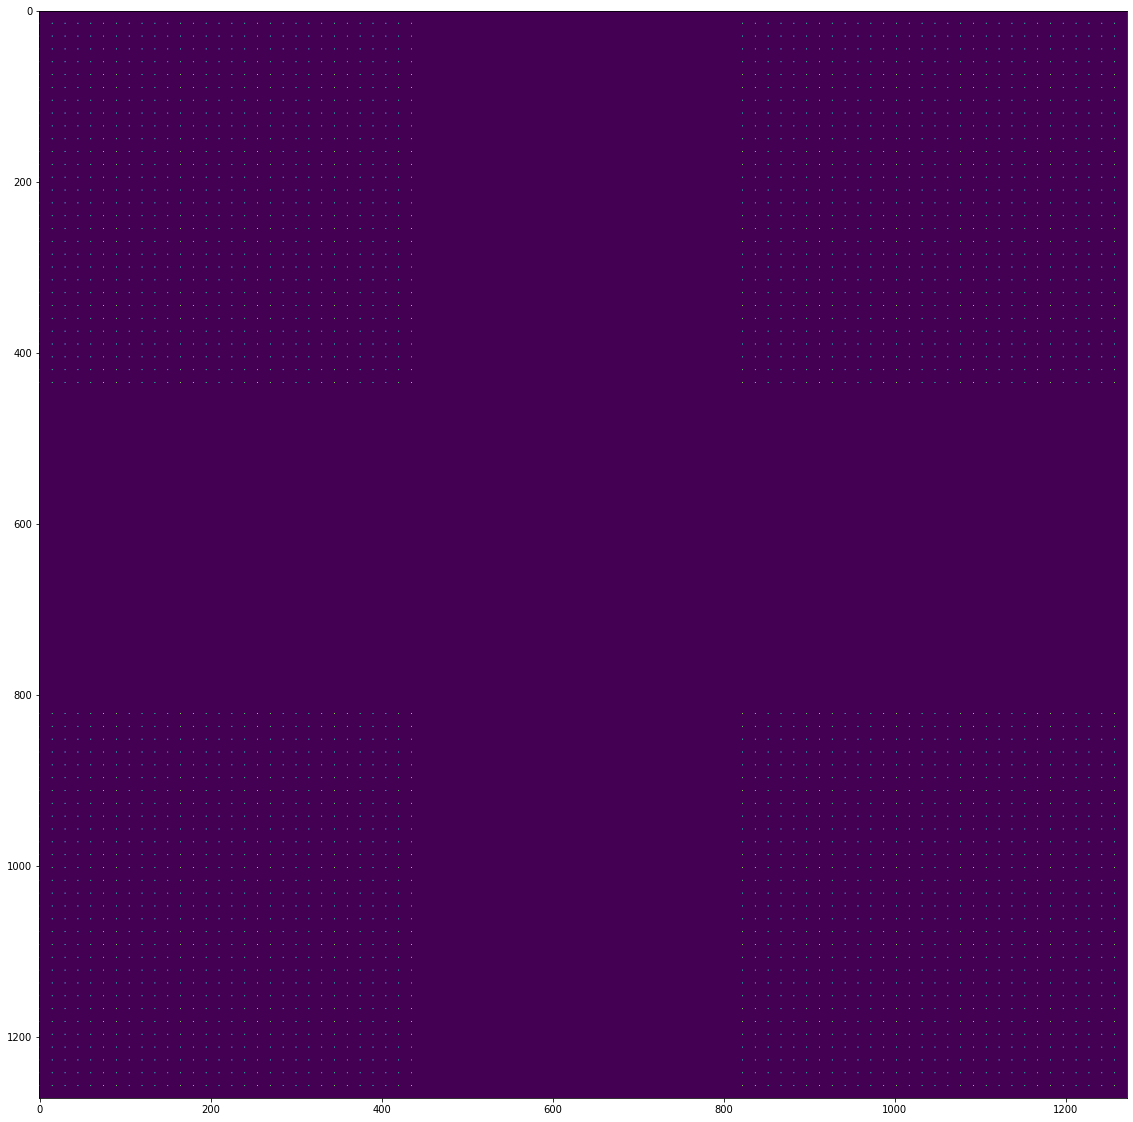

In [6]:
# We're using a complex array to represent the electric field in the trap plane.
# This way, the electric field amplitude is found by abs(trap_plane) and the phase is np.angle(trap_plane)
trap_plane = np.zeros((n,n),dtype=complex)
trap_plane[ym,xm] = 1.0

plt.figure(figsize=(20,20))
plt.imshow(abs(trap_plane))
plt.show()

The point array looks funky because we've defined the point (0,0) to lie at the top left corner. The reason for doing this is that it's easier to work with, and will come in handy when working with the FFT functions built into numpy. The point array actually looks like this:

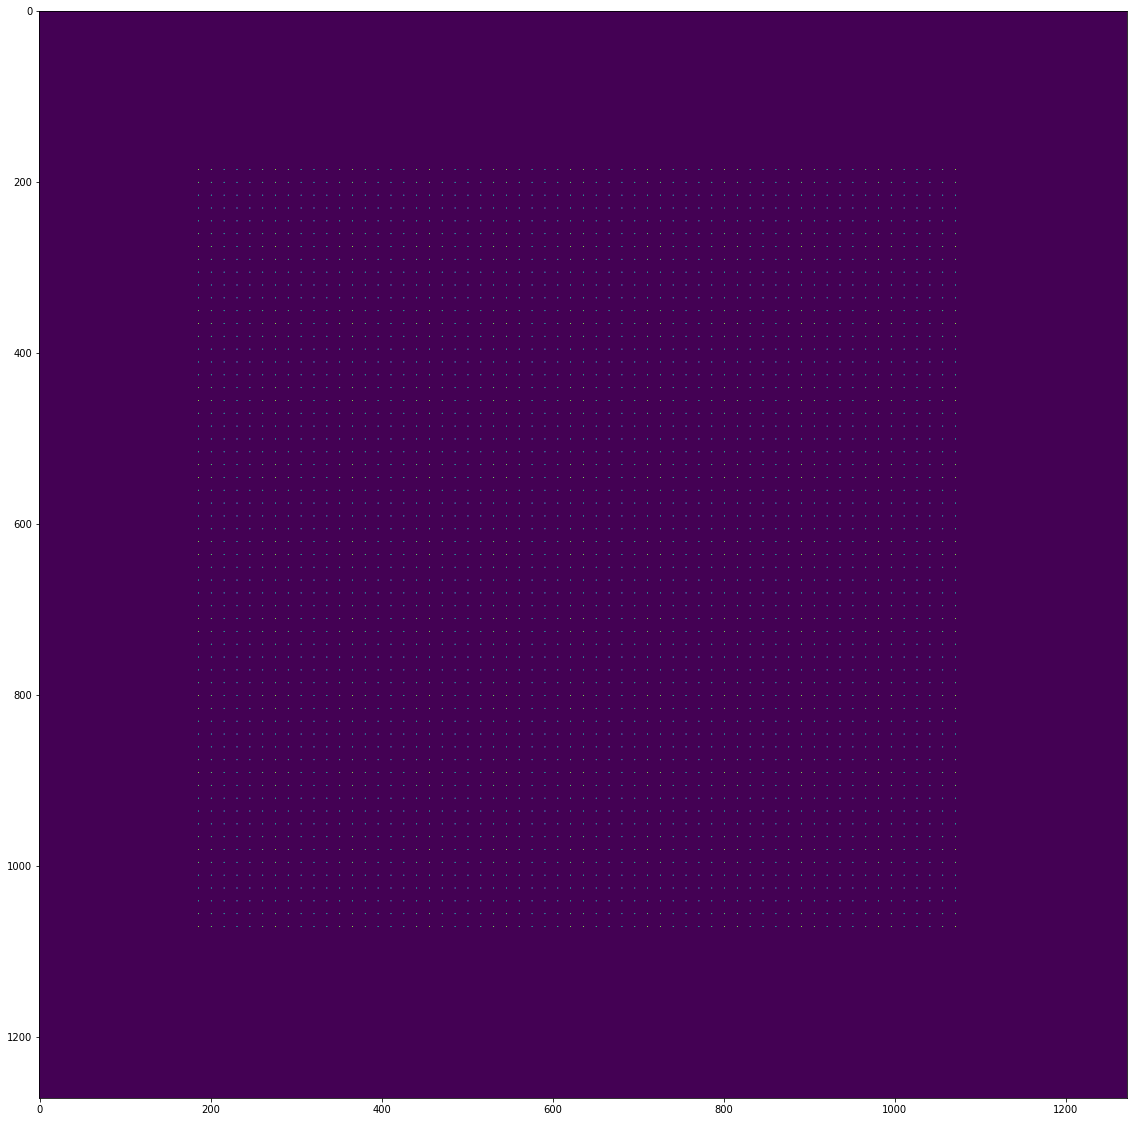

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(np.fft.fftshift(abs(trap_plane)))
plt.show()

First, we're going to make a hologram through the "Random Superposition" method, described in the paper by Leonardo. For each trap, there is a random phase theta_m corresponding to the trap's phase. We don't care about the trap phase, only the amplitude.

In [8]:
# for each trap, there is a random phase theta_m corresponding to the trap's phase
theta_m = np.random.uniform(-cmath.pi,cmath.pi,size=xm.size)

# create trap plane again
trap_plane = np.zeros((n,n), dtype=complex)

# send light to the trap locations and set the phase of the mth trap equal to theta_m
trap_plane[ym,xm] = np.exp(1j*theta_m)

The electric field at the SLM and the focal plane of the lens are related by a Fourier Transform (FT). To get the electric field at the SLM from the electric field at the focal/trap plane, perform an inverse FT.

In [9]:
# find electric field at the SLM
slm = np.fft.ifft2(trap_plane)

Now, this field has both amplitude and phase.

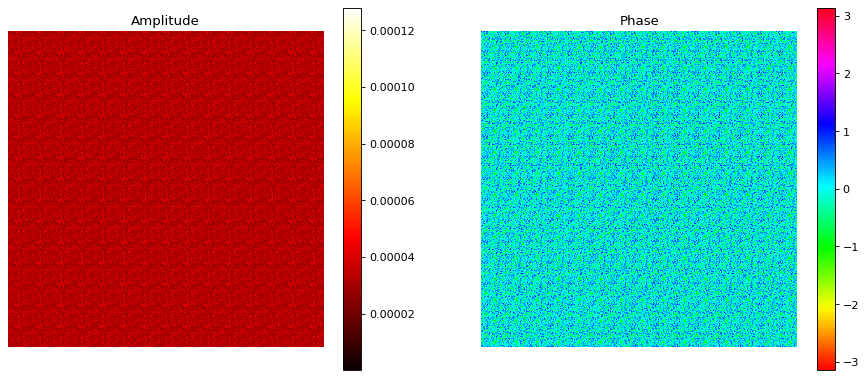

In [10]:
fig = plt.figure(figsize=(14,6), dpi=80)
ax1 =  fig.add_subplot(121)
ax2 = fig.add_subplot(122)

col1 = ax1.imshow(abs(slm), cmap='hot'); ax1.axis('off'); ax1.set_title('Amplitude')
col2 = ax2.imshow(np.angle(slm),cmap='hsv', vmin = -cmath.pi, vmax = cmath.pi); ax2.axis('off'); ax2.set_title('Phase')

fig.colorbar(col1, ax=ax1)
fig.colorbar(col2, ax=ax2)

plt.show()

In the SR algorithm, we simply drop the amplitude and replace it with a uniform field. We take only the phase because we cannot modulate amplitude with a phase-only SLM. Even with only the phase, we get a pretty good result. 

In [11]:
# find slm phase
slm_phase = np.angle(slm)

# create new slm field
slm = np.exp(1j*slm_phase)

# take the fourier transform to look at the trap plane
ft = np.fft.fft2((slm))

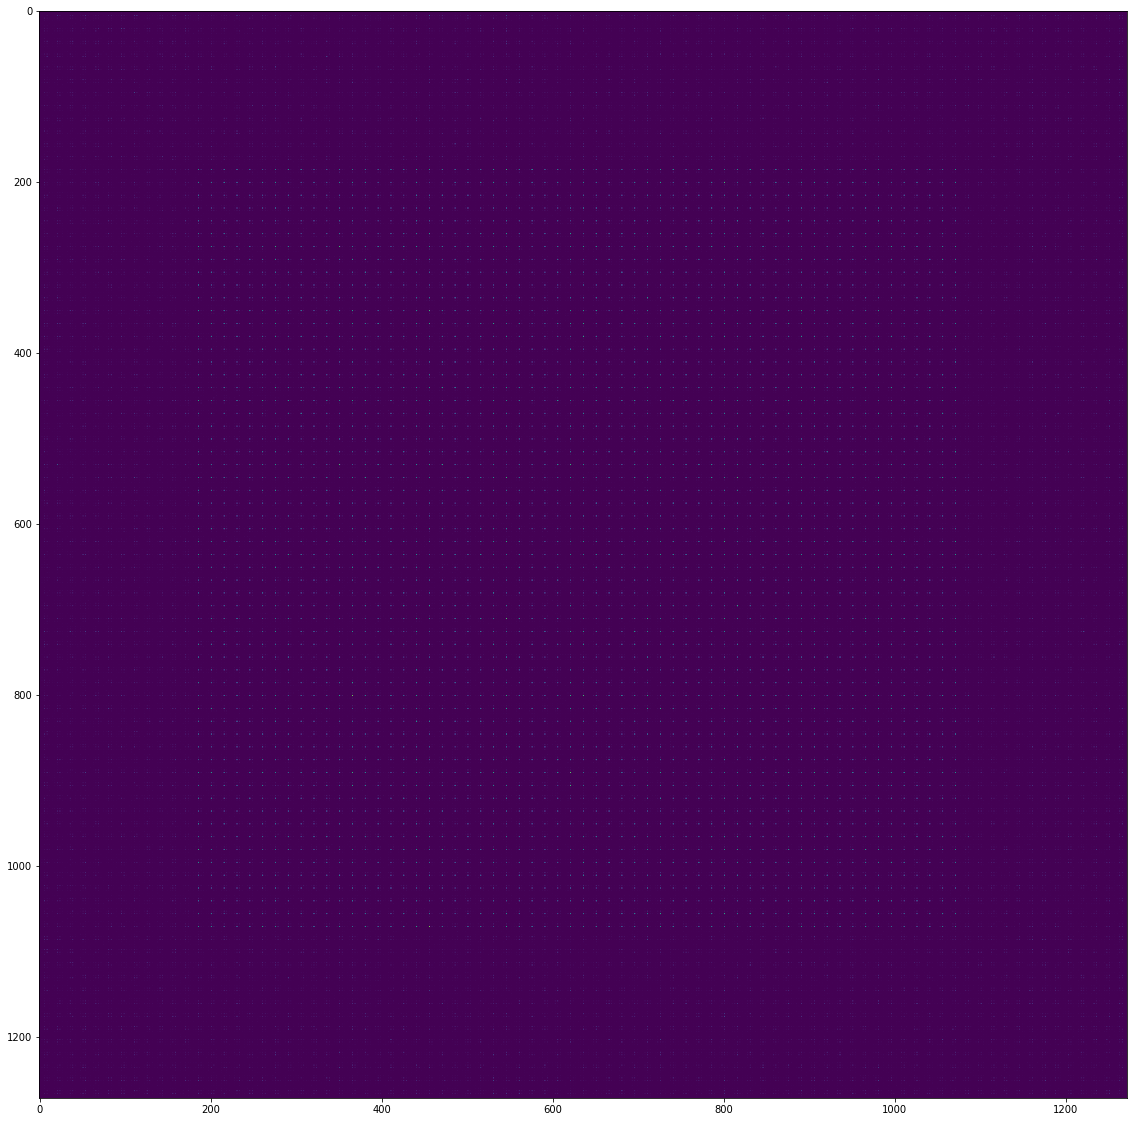

In [12]:
# Observe the generated field amplitude in the trap plane. Remember, we don't care about phase
plt.figure(figsize=(20,20))
plt.imshow(np.fft.fftshift(abs(ft)))
plt.show()

Pretty good, but we can do better! Let's evaluate the performance of our hologram according to the standards described in Leonardo's paper, where e is efficiency, u is uniformity, and sigma is percent standard deviations.

In [13]:
def perf(xm,ym,sim):
    # inputs:
        # xm, ym are the target trap coordinates
    
    # output: 
        # e = efficiency
        # u = uniformity
        # sigma = stdev in %

    # get amplitude of sim at the trap coordinates
    sim_trap_vals = abs(sim[ym.astype(int),xm.astype(int)])

    # get simulated trap intensities
    ITraps = np.square(sim_trap_vals)

    # calculate the efficiency
    Iwhole = np.sum(np.square(abs(sim))) # calculate the total intensity in the simulated plane. Will divide trap intensity sum by this amt
    Isum = np.sum(ITraps) # calculate the sum of the simulated trap intensities
    e = Isum/Iwhole

    # calculate the uniformity
    trapMax = np.amax(ITraps); trapMin = np.amin(ITraps) # get max and min trap intensity vals
    u = 1 - (trapMax - trapMin)/(trapMax + trapMin)

    # calculate the % stdev
    IAvg = np.mean(ITraps)
    inBrackets = np.square(np.add(ITraps,-IAvg))#(I - <I>)^2
    sigma = cmath.sqrt(np.mean(inBrackets))/IAvg

    return [e,u,sigma]

In [14]:
print("e, u, \u03C3 = " + str(perf(xm,ym,ft)))

e, u, σ = [0.850591292683668, 0.05025969187242085, (0.38978534107533575+0j)]


The uniformity should be pretty bad. We're going to use this result as the starting point for our GSW algorithm, which creates much better uniformity. We could really start with a random choice of SLM phase, but Leonardo's paper chooses the SR result. Let's define a funciton that outputs a CGH created with the GSW algorithm.

In [15]:
def GSW(slm_phase,xm,ym,g,niter,F,showGraph=False):

    # inputs:
        # slm_phase: square array with initial guess for the slm phase, with values btween -pi and pi. 0th spatial coordinate in corner (0,0)
        # xm, ym: both 1D arrays with the x and y coords of each trap, in order
        # g: weights applied to trap amplitudes
        # niter: number of iterations in the algorithm
        # F: number of iterations after which trap phase becomes fixed. See Donggyu Kim's paper for det
        # showGraph: when true, graphs of the target and resulting signal plane are shown

    # output: slm_phase, performance, g
        # slm_phase: 2D array of values between -pi and pi. Values come from the optimization of the slm phase using the GS method. 0th spatial coordinate in corner (0,0)
        # performance: [e, u, sigma] where e is efficiency, u is uniformity, and sigma is fractional standard deviation, as defined in Leonardo et. al.

    # get square array dimension
    n = slm_phase.shape[0]
    if slm_phase.shape[0] != slm_phase.shape[1]:
        raise Exception("Please use a square input array. The dimensions of the current input are not square.")

    # initialize array for the complex trap plane
    trap_plane = np.zeros((n,n),dtype=complex)

    for i in range(niter):
        
        print("GSW iteration number: " + str(i), end="\r")  

        # set slm electric field (assumed uniform amplitude, known phase)
        slm = np.exp(1j*slm_phase)

        # take the Fourier transform to get signal
        sig = np.fft.fft2(slm)

        # extract amplitude and phase
        trap_amps = abs(sig)[ym,xm]

        # only extract new trap phase if i<=F
        if i<=F:
            trap_phase = np.angle(sig)[ym,xm]

        # find average trap amplitude
        avg_trap_amp = np.mean(trap_amps)

        # divide avg trap amplitude by trap amplitude to get 1d array, length M, of <|V_m|>/|V_m|
        weight_frac = np.divide(avg_trap_amp,trap_amps)

        # increment g
        g = np.multiply(g,weight_frac)

        # update trap_plane
        trap_plane[ym,xm] = np.multiply(g,np.exp(1j*trap_phase))

        # transform back to the SLM plane
        slm = np.fft.ifft2(trap_plane) # np.multiply(T,np.exp(1j*trap_phase)) is the complex field in the trap plane

        # update slm phase
        slm_phase = np.angle(slm)

    print("")

    # evaluate performance at the trap plane
    trap_plane = np.fft.fft2(np.exp(1j*slm_phase))
    performance = perf(xm,ym,trap_plane)

    return slm_phase, performance

In [16]:
# initialize weights
g = np.ones(xm.size,dtype=float)

# run the algorithm
slm_phase, perf_GSW = GSW(slm_phase,xm,ym,g,niter=30,F=20)
print("e, u, \u03C3 = " + str(perf_GSW)) # this tells us how well hologram created by the GSW algorithm performed

GSW iteration number: 29
e, u, σ = [0.92214297443132, 0.9936677337853735, (0.002110217726347311+0j)]


Let's have a look at the point array we've created

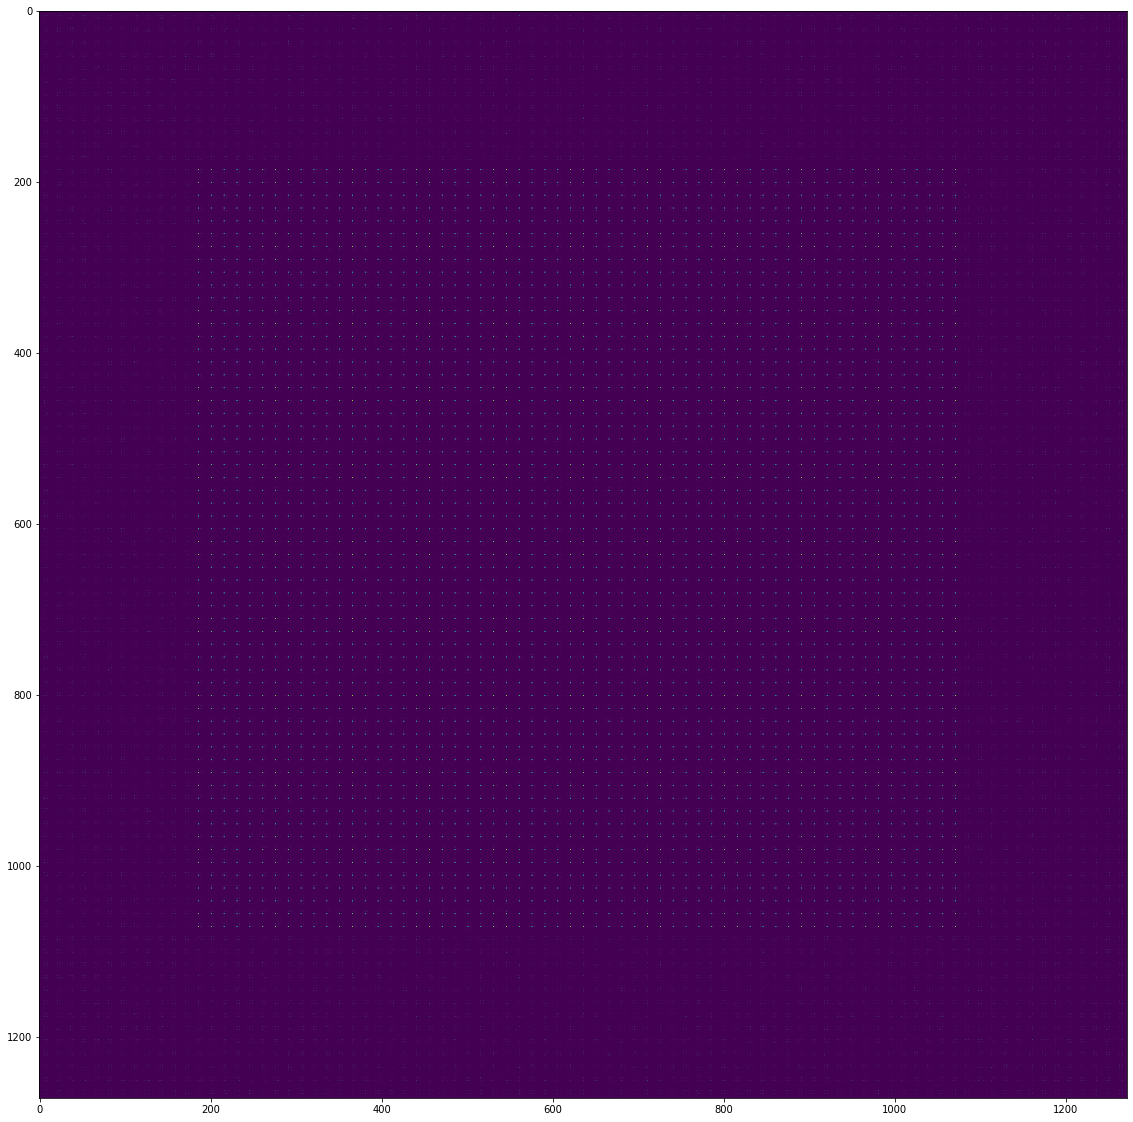

In [17]:
slm = np.exp(1j*slm_phase)
ft = np.fft.fft2(slm)

plt.figure(figsize=(20,20))
plt.imshow(np.fft.fftshift(abs(ft)))
plt.show()

And now, let's look at the hologram on the SLM. We'll have to crop it to fit the SLM display

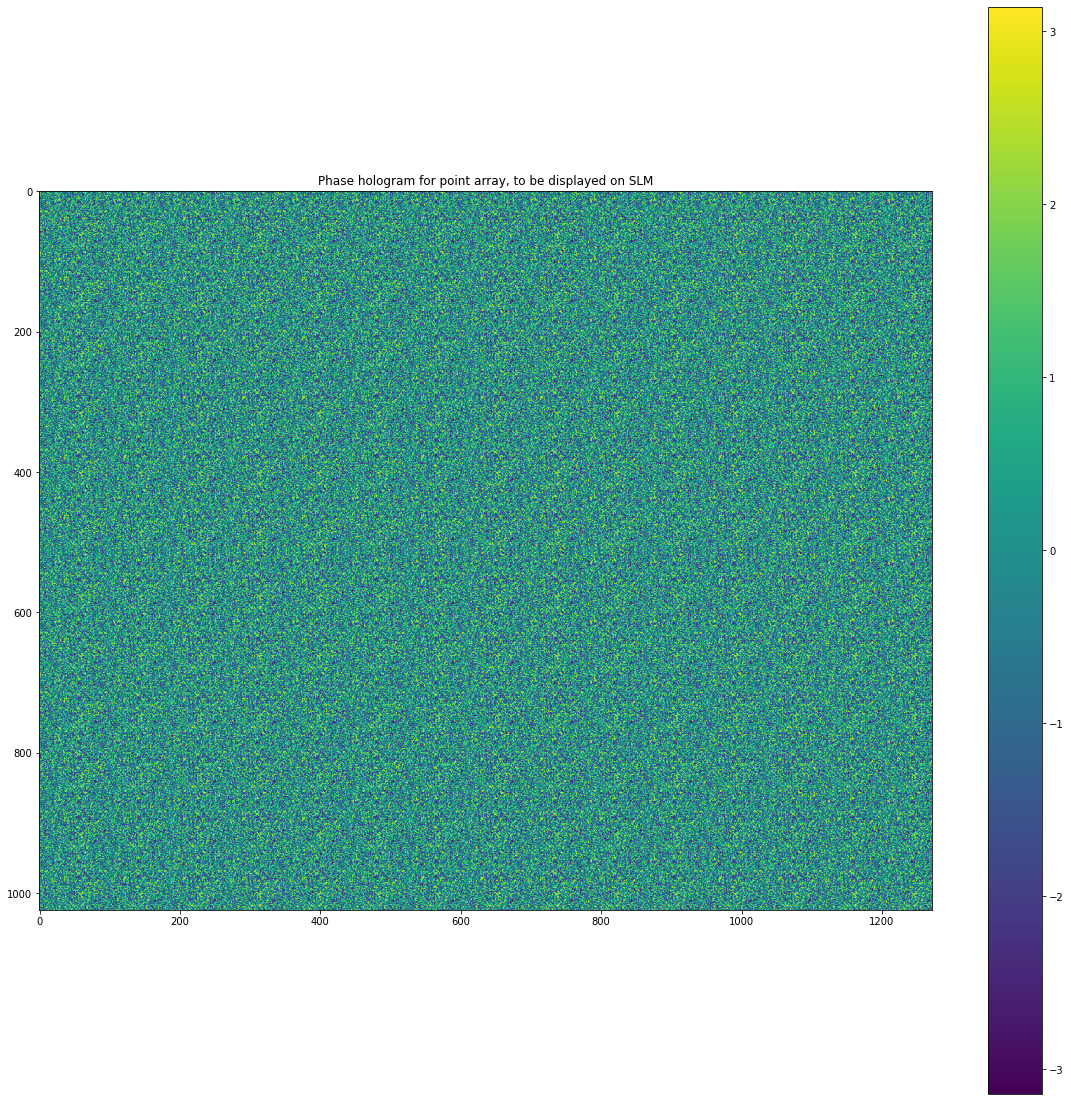

In [18]:
# Crop array so that it fits on the SLM
slm_phase_cropped = slm_phase[0:Ny,0:Nx]

plt.figure(figsize=(20,20))
plt.imshow(np.fft.fftshift(slm_phase_cropped))
plt.title("Phase hologram for point array, to be displayed on SLM")
plt.colorbar()
plt.show()

Now all that's left to do is to convert slm_phase_cropped into an image that you can display on your phase SLM and save it. 

Of course, there will be some additional problems to solve, such as the presence of a spot created by unmodulated light and the non-uniformity created by the non-ideal optics. I found that a lens phase added on top of the CGH will shift the image plane of the hologram away from the focal plane of the lens, where the image of the unmodulated point is formed. To tackle the correction of non-uniformity that comes from an imperfect imaging system, see Donggyu Kim's paper for an adaptive correction method.